In [1]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from catboost import CatBoostClassifier, Pool

In [3]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import joblib

# Load your train and test data
train_df = pd.read_csv('train.csv', encoding='utf-8')
test_df = pd.read_csv('test.csv', encoding='utf-8')

# Identify the categorical columns
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Initialize a dictionary to store the label encoders
label_encoders = {}

# Encode categorical columns for both train and test data
for col in categorical_columns:
    label_encoder = LabelEncoder()
    # Fit the label encoder on the training data and transform it
    train_df[col] = label_encoder.fit_transform(train_df[col].astype(str))
    # Use the fitted encoder to transform the test data
    test_df[col] = label_encoder.transform(test_df[col].astype(str))
    
    # Save the label encoder to the dictionary
    label_encoders[col] = label_encoder

# Optionally: Save the encoded data back to CSV
train_df.to_csv('train_encoded.csv', index=False)
test_df.to_csv('test_encoded.csv', index=False)

# Save the label encoders to disk
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

In [4]:
train_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,3,0.0,1,1,6000,11.49,0.17,0,14,0
1,1,22,56000,2,6.0,3,2,4000,13.35,0.07,0,2,0
2,2,29,28800,2,8.0,4,0,6000,8.90,0.21,0,10,0
3,3,30,70000,3,14.0,5,1,12000,11.11,0.17,0,5,0
4,4,22,60000,3,2.0,3,0,6000,6.92,0.10,0,3,0


In [5]:
print(f"Train Dataset Shape: {train_df.shape}")
print(f"Test Dataset Shape: {test_df.shape}")

Train Dataset Shape: (58645, 13)
Test Dataset Shape: (39098, 12)


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  int32  
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  int32  
 6   loan_grade                  58645 non-null  int32  
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  int32  
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int32(4), int64(

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  int32  
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  int32  
 6   loan_grade                  39098 non-null  int32  
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  int32  
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int32(4), int64(5)
memory usage: 3.0 MB


In [8]:
common_columns = set(train_df.columns) & set(test_df.columns)
uncommon_columns = set(train_df.columns) ^ set(test_df.columns)  # XOR operation to get differences

print(f"Common Columns: {common_columns}\n")
print(f"Uncommon Columns: {uncommon_columns}\n")

Common Columns: {'person_emp_length', 'loan_intent', 'loan_percent_income', 'loan_amnt', 'loan_int_rate', 'person_age', 'id', 'person_income', 'cb_person_default_on_file', 'loan_grade', 'cb_person_cred_hist_length', 'person_home_ownership'}

Uncommon Columns: {'loan_status'}



In [9]:
train_df.loan_status.value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

C:\Users\Eishan\AppData\Local\Temp\ipykernel_10792\3665028203.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loan_status_counts.index, y=loan_status_counts.values, palette="viridis")


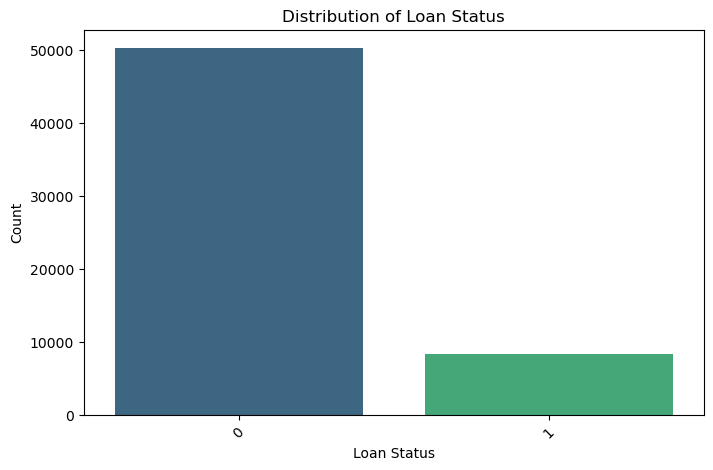

In [10]:
# Count the occurrences of each class in loan_status
loan_status_counts = train_df["loan_status"].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=loan_status_counts.index, y=loan_status_counts.values, palette="viridis")

# Labels and title
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.title("Distribution of Loan Status")
plt.xticks(rotation=45)  # Rotate labels if needed
plt.show()

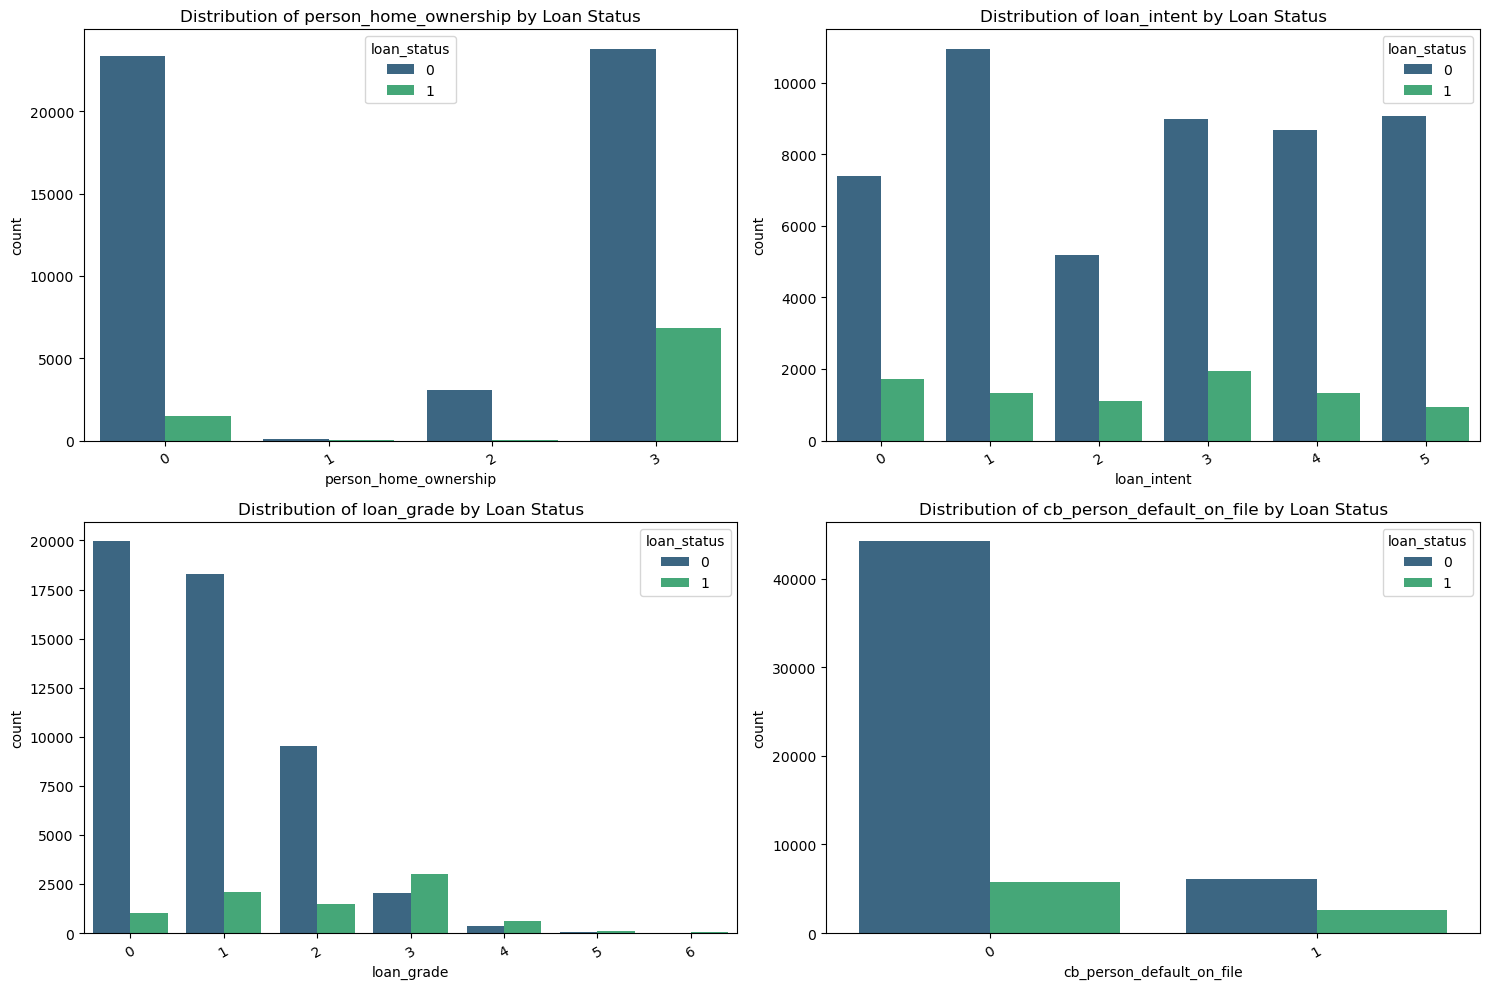

In [11]:
# Plotting the categorical data with respect to the loan_status, which is our target variable

categorical_features = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]

plt.figure(figsize=(15, 10))

# Loop through each categorical variable and create a count plot
for i, col in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid for subplots
    sns.countplot(data=train_df, x=col, hue="loan_status", palette="viridis")
    plt.title(f"Distribution of {col} by Loan Status")
    plt.xticks(rotation=30)  # Rotate labels for better readability

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

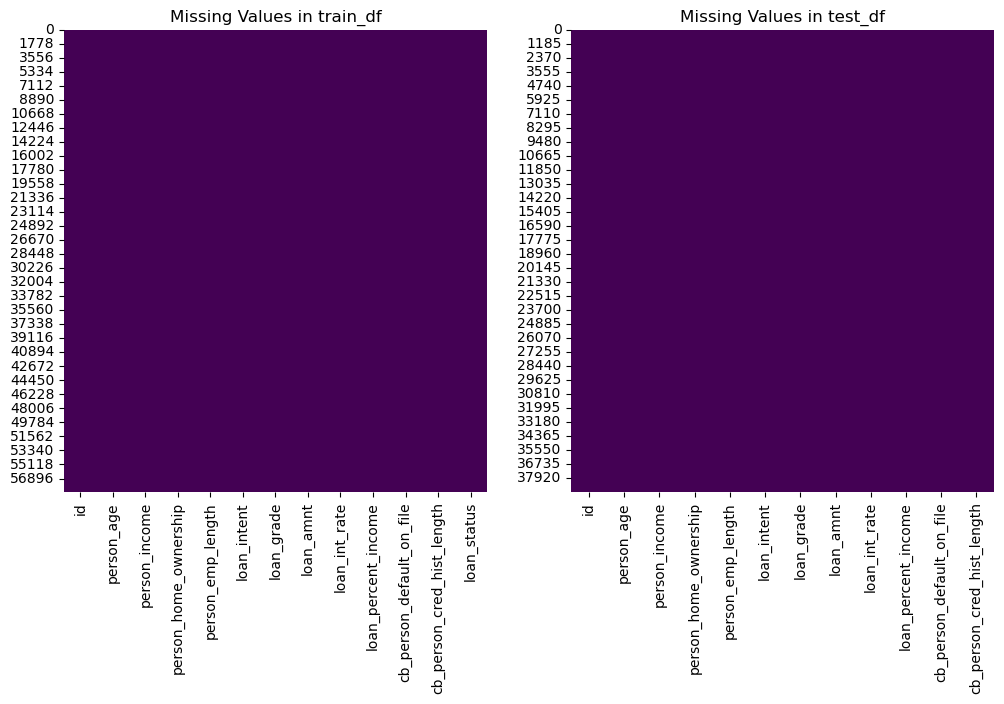

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in train_df")

plt.subplot(1, 2, 2)
sns.heatmap(test_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in test_df")

plt.show()

In [13]:
print(f"Number of duplicate values in Train dataset: {train_df.duplicated().sum()}")
print(f"Number of duplicate values in Test dataset: {test_df.duplicated().sum()}")

Number of duplicate values in Train dataset: 0
Number of duplicate values in Test dataset: 0


In [14]:
train_df['person_home_ownership'].unique()

array([3, 2, 0, 1])

In [15]:
train_df['loan_intent'].unique()

array([1, 3, 4, 5, 0, 2])

In [16]:
train_df['loan_grade'].unique()

array([1, 2, 0, 3, 4, 5, 6])

In [17]:
train_df['cb_person_default_on_file'].unique()

array([0, 1])

In [18]:
df = train_df.copy()

In [19]:
# Define features (X) and target (y)
X = df.drop(columns=["loan_status"])  # Drop target variable
y = df["loan_status"]  # Target variable

In [20]:
# Identify categorical features
categorical_features = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]

# Encode categorical features
encoder = OrdinalEncoder()
X[categorical_features] = encoder.fit_transform(X[categorical_features])

In [21]:
# Compute Mutual Information
mutual_info = mutual_info_classif(X, y, random_state=42)

# Convert to Pandas Series
mutual_info = pd.Series(mutual_info, index=X.columns)

# Sort values in descending order
mutual_info = mutual_info.sort_values(ascending=False)

# Display results
mutual_info_df = pd.DataFrame(mutual_info, columns=['Mutual Information'])
print(mutual_info_df)

                            Mutual Information
person_income                         0.099013
loan_percent_income                   0.081107
loan_grade                            0.081019
loan_int_rate                         0.079717
person_home_ownership                 0.037772
loan_amnt                             0.017547
cb_person_default_on_file             0.014998
loan_intent                           0.009338
person_emp_length                     0.008439
person_age                            0.004770
id                                    0.000000
cb_person_cred_hist_length            0.000000


C:\Users\Eishan\AppData\Local\Temp\ipykernel_10792\3662850162.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mutual_info, y=mutual_info.index, palette="RdYlGn")


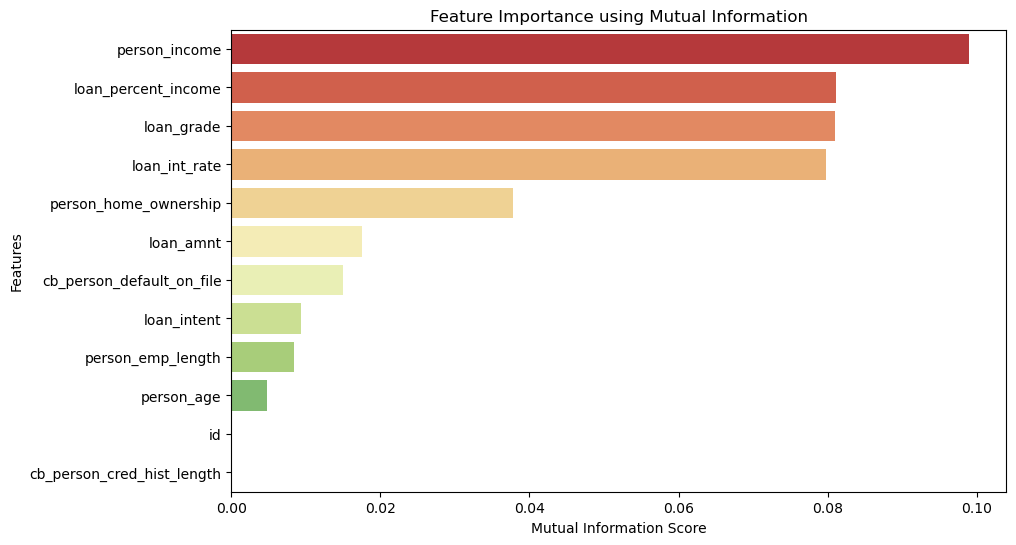

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x=mutual_info, y=mutual_info.index, palette="RdYlGn")
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.title("Feature Importance using Mutual Information")
plt.show()

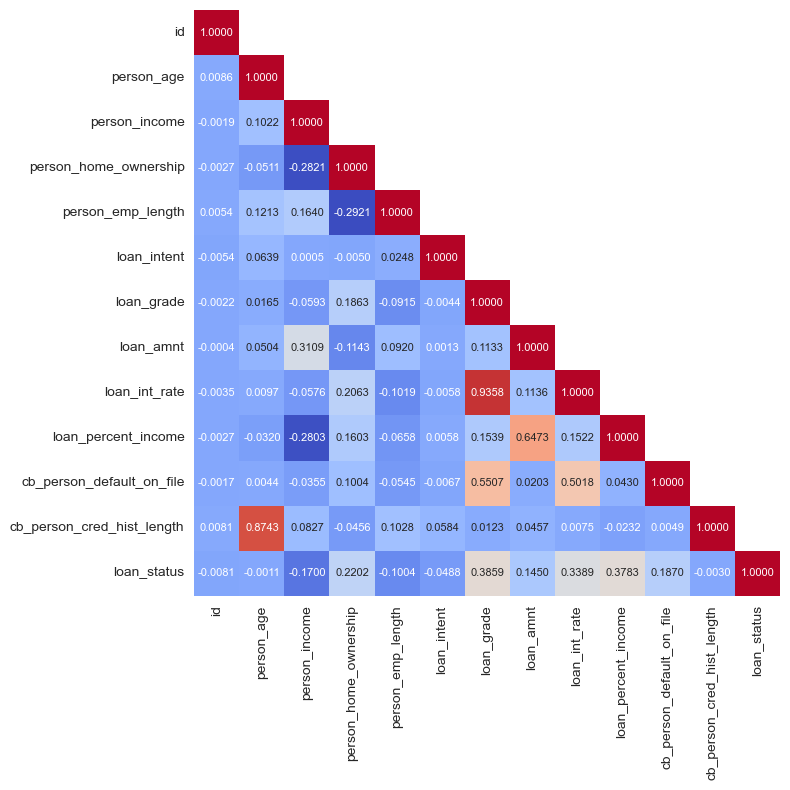

In [23]:
sns.set_style("white")
plt.figure(figsize=(8, 8))

corr_train = pd.concat([X, y], axis=1).corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)

sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.4f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    annot_kws={'size': 8},
    cbar=False
)

plt.tight_layout()
plt.show()

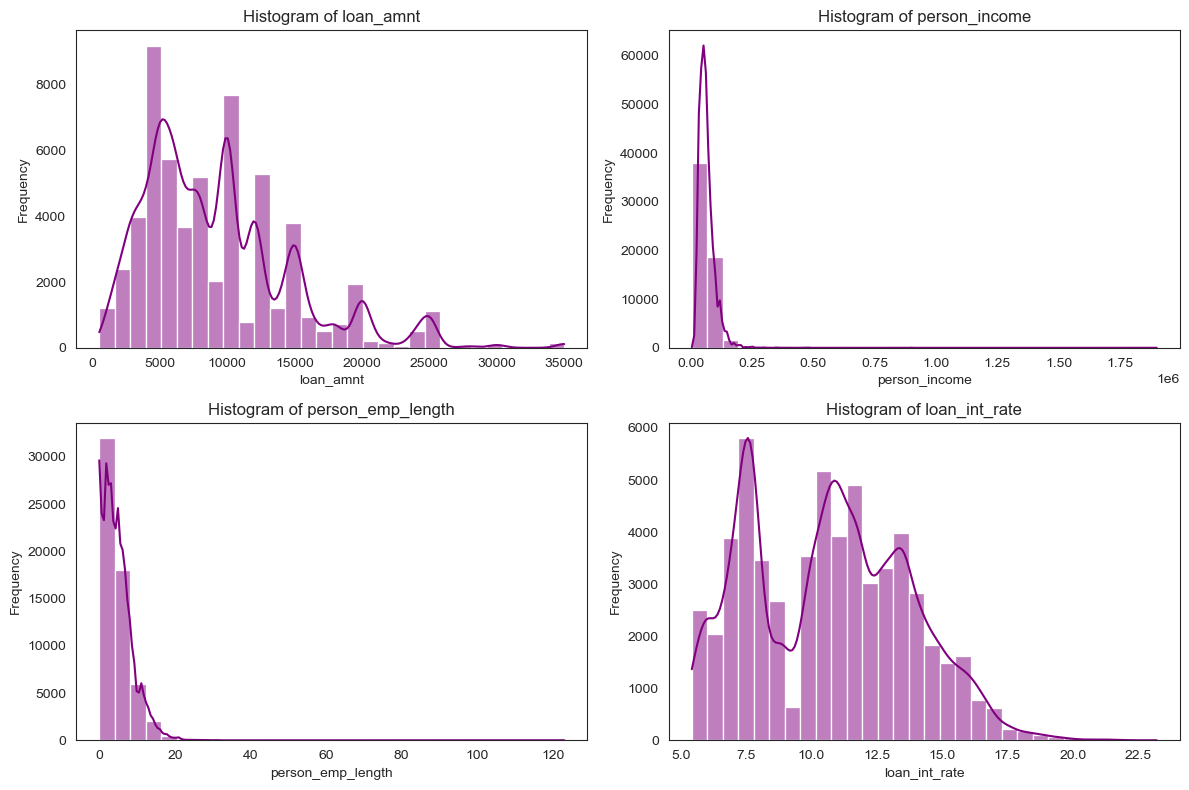

In [24]:
# -------------------------------------------
# Histogram: Distribution of Numerical Features
# -------------------------------------------
# This section creates histograms for numerical features to analyze their distributions.
# The KDE (Kernel Density Estimate) helps visualize the probability distribution.
# -------------------------------------------

# Selecting numerical features
numerical_features = ["loan_amnt", "person_income", "person_emp_length", "loan_int_rate"]

plt.figure(figsize=(12, 8))

# Loop through each numerical variable and create a histogram
for i, col in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid for subplots
    sns.histplot(train_df[col], bins=30, kde=True, color="purple")
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

C:\Users\Eishan\AppData\Local\Temp\ipykernel_10792\4107761184.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x="loan_status", y=col, palette="coolwarm")
C:\Users\Eishan\AppData\Local\Temp\ipykernel_10792\4107761184.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x="loan_status", y=col, palette="coolwarm")
C:\Users\Eishan\AppData\Local\Temp\ipykernel_10792\4107761184.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x="loan_status", y=col, palette="coolwarm")
C:\Users\Eishan\AppData\L

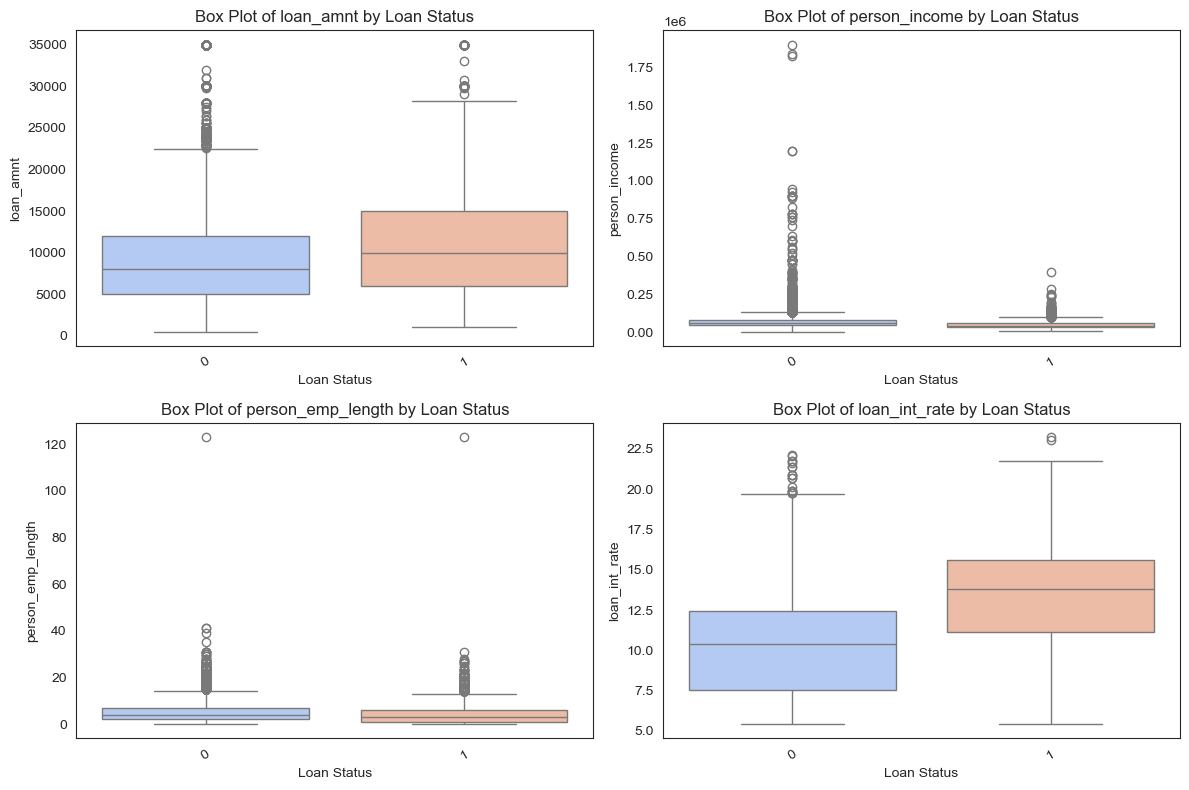

In [25]:
# -------------------------------------------
# Box Plot: Distribution of Numerical Features by Loan Status
# -------------------------------------------
# Box plots are useful for identifying outliers and comparing distributions.
# This section visualizes the spread of numerical features across different loan statuses.
# -------------------------------------------

plt.figure(figsize=(12, 8))

# Loop through each numerical variable and create a box plot
for i, col in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid for subplots
    sns.boxplot(data=train_df, x="loan_status", y=col, palette="coolwarm")
    plt.title(f"Box Plot of {col} by Loan Status")
    plt.xlabel("Loan Status")
    plt.ylabel(col)
    plt.xticks(rotation=30)  # Rotate labels for better readability

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [26]:
def prepare(train_df, test_df, categorical_features):
  
    for column in categorical_features:
        e = LabelEncoder()
        train_df[column] = e.fit_transform(train_df[column])
        test_df[column] = e.transform(test_df[column])  # Transform using the same encoder

    return train_df, test_df

In [27]:
categorical_features = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]
train_df, test_df = prepare(train_df, test_df, categorical_features)

In [28]:
features = train_df.drop(["loan_status"], axis=1)
label = train_df["loan_status"]

In [29]:
features.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,0,37,35000,3,0.0,1,1,6000,11.49,0.17,0,14
1,1,22,56000,2,6.0,3,2,4000,13.35,0.07,0,2
2,2,29,28800,2,8.0,4,0,6000,8.90,0.21,0,10
3,3,30,70000,3,14.0,5,1,12000,11.11,0.17,0,5
4,4,22,60000,3,2.0,3,0,6000,6.92,0.10,0,3


In [30]:
label.head()

0    0
1    0
2    0
3    0
4    0
Name: loan_status, dtype: int64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=40)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [33]:
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

In [34]:
clfs = {
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'ETC': etc,
}

In [35]:
def train_classifier(clf, X_train, y_train, X_test, y_test):

    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Predict class labels for X_test
    y_pred = clf.predict(X_test)
    
    # Predict probabilities for X_test
    y_proba = clf.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    ruc_score = roc_auc_score(y_test, y_proba)

    return accuracy, precision, ruc_score

In [36]:
# Define hyperparameter grids for tuning
param_grids = {
    'DT': {'max_depth': [3, 5, 10, None]},
    'LR': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
    'RF': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
    'ETC': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
}

best_models = {}

In [37]:
for name, clf in clfs.items():
    print(f"Tuning hyperparameters for {name}...")
    
    if name in param_grids and param_grids[name]:
        search = GridSearchCV(clf, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
        search.fit(X_train, y_train)
        best_models[name] = search.best_estimator_
        print(f"Best parameters for {name}: {search.best_params_}")
    else:
        best_models[name] = clf.fit(X_train, y_train) 


Tuning hyperparameters for DT...
Best parameters for DT: {'max_depth': 10}
Tuning hyperparameters for LR...
Best parameters for LR: {'C': 1, 'penalty': 'l1'}
Tuning hyperparameters for RF...
Best parameters for RF: {'max_depth': None, 'n_estimators': 200}
Tuning hyperparameters for AdaBoost...


C:\Users\Eishan\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 200}
Tuning hyperparameters for ETC...
Best parameters for ETC: {'max_depth': None, 'n_estimators': 200}


In [38]:
# Evaluate tuned models
accuracy_scores, precision_scores, ruc_scores = [], [], []

for name, clf in best_models.items():
    current_accuracy, current_precision, current_ruc_auc_score = train_classifier(clf, X_train, y_train, X_test, y_test)
    print("================================================================================")
    print(f"For {name}")
    print(f"Accuracy - {current_accuracy}")
    print(f"Precision - {current_precision}")
    print(f"RUC_AUC_SCORE - {current_ruc_auc_score}")
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    ruc_scores.append(current_ruc_auc_score)

For DT
Accuracy - 0.947736379913036
Precision - 0.9002356637863315
RUC_AUC_SCORE - 0.901444651100016
For LR
Accuracy - 0.8976042288345127
Precision - 0.7275607180570222
RUC_AUC_SCORE - 0.8789592666818139
For RF
Accuracy - 0.9516582828885668
Precision - 0.9411764705882353
RUC_AUC_SCORE - 0.9300972964207967


C:\Users\Eishan\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


For AdaBoost
Accuracy - 0.9297467814817972
Precision - 0.8151326053042122
RUC_AUC_SCORE - 0.9253645278057743
For ETC
Accuracy - 0.9485037087560747
Precision - 0.9151857835218093
RUC_AUC_SCORE - 0.9224828902294798


In [39]:
performance_df = pd.DataFrame({'ALGORITHM':clfs.keys(),'ACCURACY':accuracy_scores,'PRECISION':precision_scores, 'RUC_AUC_SCORE': ruc_scores}).sort_values('RUC_AUC_SCORE',ascending=False)
performance_df.head()

,ALGORITHM,ACCURACY,PRECISION,RUC_AUC_SCORE
2,RF,0.951658,0.941176,0.930097
3,AdaBoost,0.929747,0.815133,0.925365
4,ETC,0.948504,0.915186,0.922483
0,DT,0.947736,0.900236,0.901445
1,LR,0.897604,0.727561,0.878959


In [40]:
performance_df1 = pd.melt(performance_df, id_vars = "ALGORITHM")
performance_df1

,ALGORITHM,variable,value
0,RF,ACCURACY,0.951658
1,AdaBoost,ACCURACY,0.929747
2,ETC,ACCURACY,0.948504
3,DT,ACCURACY,0.947736
4,LR,ACCURACY,0.897604
5,RF,PRECISION,0.941176
6,AdaBoost,PRECISION,0.815133
7,ETC,PRECISION,0.915186
8,DT,PRECISION,0.900236
9,LR,PRECISION,0.727561


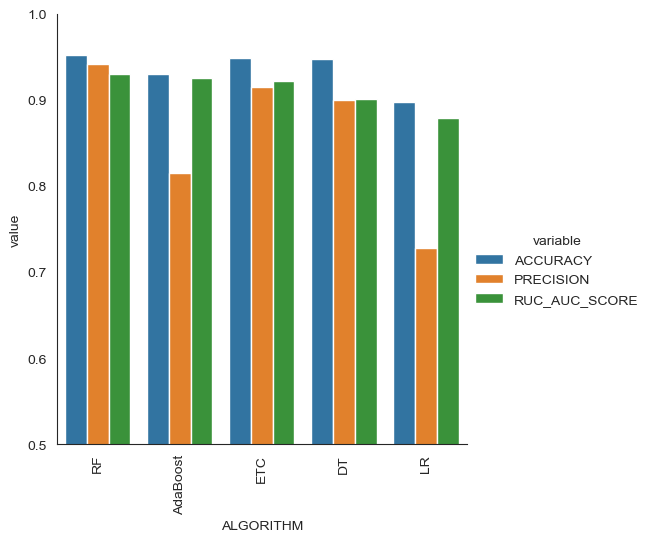

In [41]:
sns.catplot(x = 'ALGORITHM', y='value', hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

In [42]:
# Save the best performing model
best_model_name = max(best_models, key=lambda name: train_classifier(best_models[name], X_train, y_train, X_test, y_test)[0])
best_model = best_models[best_model_name]

joblib.dump(best_model, 'best_model.pkl')

C:\Users\Eishan\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


['best_model.pkl']

In [43]:
# Predict on test set using the best model
y_pred = best_model.predict(test_df)
y_pred_proba = best_model.predict_proba(test_df)

submission = pd.DataFrame({'id': test_df['id'], 'loan_status': y_pred})
submission.to_csv('submission.csv', index=False)
